In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stat
import csv
import requests
import os
import PIL
from PIL import Image
import random
import torch
import cv2
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import glob
from tqdm import tqdm
from collections import Counter
from seaborn import set_style
set_style('white')

In [2]:
Y_train=pd.read_csv('data/Y_train.csv')
Y_train

    

,High,Low,return,hrate%,lrate%,rrate%,hcl,lcl,rcl
0,415.0850,413.745,414.8150,0.323871,0.000000,0.258613,0.25%~0.35%,-0.05%~0.05%,0.25%~0.35%
1,415.0850,413.860,414.9500,0.240286,-0.055543,0.207684,0.15%~0.25%,-0.15%~-0.05%,0.15%~0.25%
2,415.0850,413.860,415.0100,0.199150,-0.096558,0.181046,0.15%~0.25%,-0.15%~-0.05%,0.15%~0.25%
3,415.0850,413.860,415.0400,0.210036,-0.085704,0.199172,0.15%~0.25%,-0.15%~-0.05%,0.15%~0.25%
4,415.1086,413.860,415.1086,0.250827,-0.050716,0.250827,0.25%~0.35%,-0.15%~-0.05%,0.25%~0.35%
...,...,...,...,...,...,...,...,...,...
19407,445.1300,444.610,445.0400,0.029213,-0.087640,0.008989,-0.05%~0.05%,-0.15%~-0.05%,-0.05%~0.05%
19408,445.2000,444.610,445.2000,0.041572,-0.091008,0.041572,-0.05%~0.05%,-0.15%~-0.05%,-0.05%~0.05%
19409,445.3250,444.610,445.3250,0.076407,-0.084273,0.076407,0.05%~0.15%,-0.15%~-0.05%,0.05%~0.15%
19410,445.3250,444.610,445.3200,0.086529,-0.074167,0.085405,0.05%~0.15%,-0.15%~-0.05%,0.05%~0.15%


In [3]:
#Use the three columns 'hcl','lcl','rcl' classified before according to 'hrate','lrate','rrate'
classes=['<-0.35%','-0.35%~-0.25%','-0.25%~-0.15%','-0.15%~-0.05%','-0.05%~0.05%',
         '0.05%~0.15%','0.15%~0.25%','0.25%~0.35%','>0.35%']

target='hcl'        #set the classification target from 'hcl', 'lcl', or 'rcl' for the model
output_size=9

Ylabel=Y_train[target]       


if target=='hcl':
    classes=classes[4:]
    output_size=5
elif target=='lcl':
    classes=classes[:5]
    output_size=5

#index to class/class to index dictionary
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}



class ImgDataset(Dataset):
    def __init__(self, image_paths, label):
        self.image_paths = image_paths
        self.label=label

        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.9758, 0.9836, 0.9910), std = (0.1185, 0.0802, 0.0544))
        ])
            

        image = transform(image)
        
        label = self.label.loc[int(image_filepath.split('/')[-1][:-4])]   #get index from the filename
        label = class_to_idx[label]

        
        return image, label
    

#sort the list of paths such that they are in time order
train_image_paths=['data/CNN images/'+ x for x in sorted(os.listdir(os.getcwd()+'/data/CNN images'), key=lambda x:int(x[:-4]))]

#Train/Test split 
train_image_paths, valid_image_paths = train_image_paths[:int(0.9*len(train_image_paths))
                                                        ],train_image_paths[int(0.9*len(train_image_paths)):] 

train_data = ImgDataset(train_image_paths, Ylabel)
val_data = ImgDataset(valid_image_paths, Ylabel)



print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")


batch_size = 128
train_dl = DataLoader(train_data, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, pin_memory=True)


Length of Train Data : 17470
Length of Validation Data : 1942


In [5]:
#number of images in each class

class_count = Counter(Ylabel)
sorted(pd.Series(class_count).items(),key=lambda x: class_to_idx[x[0]])

[('-0.05%~0.05%', 5255),
 ('0.05%~0.15%', 7275),
 ('0.15%~0.25%', 4098),
 ('0.25%~0.35%', 1790),
 ('>0.35%', 994)]

The shape of tensor for the first image in train dataset: torch.Size([3, 150, 150])
Label : 0.25%~0.35%


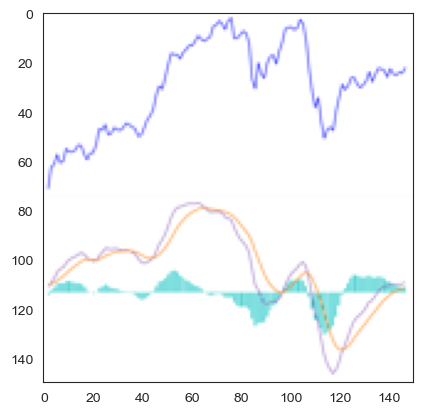

In [4]:
#show one image
def denormalize(image, batch=True):
    if batch==True:
        mean = torch.tensor((0.9758, 0.9836, 0.9910)).reshape(1, 3, 1, 1)
        std = torch.tensor((0.1185, 0.0802, 0.0544)).reshape(1, 3, 1, 1)
    else:
        mean = torch.tensor((0.9758, 0.9836, 0.9910)).reshape(3, 1, 1)
        std = torch.tensor((0.1185, 0.0802, 0.0544)).reshape(3, 1, 1)
    return image * std + mean

def display_img(img,label):
    print(f"Label : {classes[label]}")
    img=denormalize(img, batch=False)
    plt.imshow(img.permute(1,2,0))

print('The shape of tensor for the first image in train dataset:',train_data[0][0].shape)
#display the first image in the dataset
display_img(*train_data[0])

tensor([2, 1, 1, 4, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 4, 2, 2, 0, 0,
        0, 1, 0, 1, 0, 1, 2, 1, 0, 2, 2, 2, 1, 4, 2, 1, 2, 1, 0, 1, 3, 1, 1, 2,
        2, 4, 1, 2, 1, 0, 1, 2, 3, 4, 0, 3, 0, 1, 4, 0, 2, 0, 4, 0, 0, 1, 2, 1,
        1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 3, 1, 4,
        1, 2, 1, 0, 4, 1, 2, 3, 1, 2, 1, 3, 2, 2, 3, 1, 0, 0, 0, 1, 1, 1, 4, 1,
        2, 4, 2, 4, 0, 0, 0, 1])


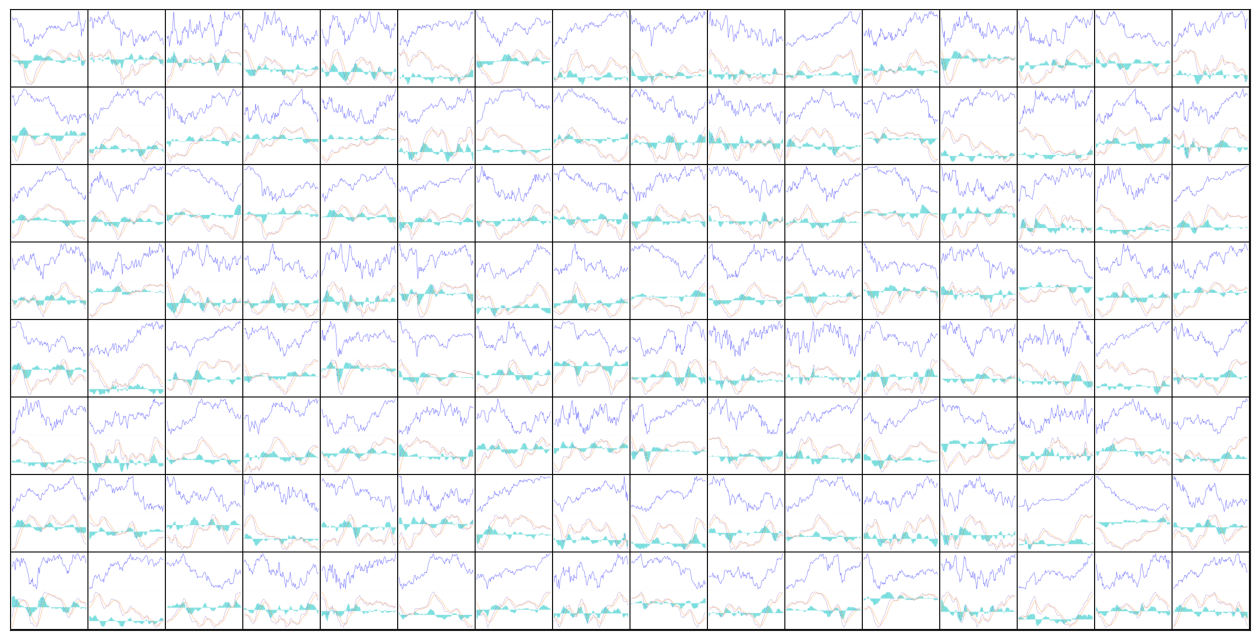

In [5]:
#show the labels and images in one batch
from torchvision.utils import make_grid


def show_batch(dl):

    for image, label in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        image = denormalize(image)
        ax.imshow(make_grid(image,nrow=16).permute(1,2,0))
        print(label)
        break
        
show_batch(train_dl)

In [8]:
#check Cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [9]:
#Use CoordConv layer to inculde (x,y)-coordinates (https://paperswithcode.com/paper/an-intriguing-failing-of-convolutional-neural)
class AddCoords(nn.Module):

    def __init__(self, with_r=False):
        super().__init__()
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """
        batch_size, _, x_dim, y_dim = input_tensor.size()

        xx_channel = torch.arange(x_dim).repeat(1, y_dim, 1)
        yy_channel = torch.arange(y_dim).repeat(1, x_dim, 1).transpose(1, 2)

        xx_channel = xx_channel.float() / (x_dim - 1)
        yy_channel = yy_channel.float() / (y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)
        yy_channel = yy_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)

        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor),
            yy_channel.type_as(input_tensor)], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel.type_as(input_tensor) - 0.5, 2) + torch.pow(yy_channel.type_as(input_tensor) - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        return ret


class CoordConv(nn.Module):

    def __init__(self, in_channels, out_channels, with_r=False, **kwargs):
        super().__init__()
        self.addcoords = AddCoords(with_r=with_r)
        in_size = in_channels+2
        if with_r:
            in_size += 1
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

    def forward(self, x):
        ret = self.addcoords(x)
        ret = self.conv(ret)
        return ret

In [10]:
# check accuracy for dataloader
def accuracy(dl,classes, model, device): 

    correct = 0
    total = 0

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    pred={classname: 0 for classname in classes}
    with torch.no_grad():
        for data in dl:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
                pred[classes[prediction]] += 1

    print(f'Accuracy of the network on the images: {100 * correct / total} %\n')
            
    for classname, correct_count in correct_pred.items():
        if total_pred[classname]!=0:
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname} is {accuracy:.1f} %')
        else:
            print('No image in the class:',classname)
        print('number of images in the class:',total_pred[classname])
        print('number of images predicted to be in the class:',pred[classname],'\n')
        
    return 100 * correct / total

In [11]:
#CNN Trainning

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            CoordConv(3, 8, kernel_size = 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            CoordConv(8, 16, kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            CoordConv(16, 16, kernel_size = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            CoordConv(16, 16, kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            CoordConv(16, 32, kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            CoordConv(32, 32, kernel_size = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(8*8*32,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

    def forward(self, xb):
        return self.net(xb)

cnn = CNN()
cnn.to(device)

#calculate class weights for CrossEntrophyLoss because of imbalanced data
class_count = Counter(Ylabel)
class_weights = torch.Tensor([len(train_data)/x[1] for x in sorted(pd.Series(class_count).items(),
                                                                key=lambda x: class_to_idx[x[0]])]) 
class_weights=class_weights.to(device)

criterion = nn.CrossEntropyLoss(class_weights)

optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=0.01)

train_rec, val_rec=[], []

for epoch in range(10):  

    running_loss = 0.0
    for i, data in enumerate(train_dl):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = cnn(inputs)
        loss = criterion(outputs.contiguous(), labels.contiguous())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f'[{epoch + 1}, {i + 1:4d}] loss: {running_loss:.3f}')
        running_loss = 0.0
        
    train_rec.append(accuracy(train_dl,classes,cnn,device))
    val_rec.append(accuracy(val_dl,classes,cnn,device))


print('Finished Training')

[1,    1] loss: 1.682
[1,    2] loss: 1.738
[1,    3] loss: 1.715
[1,    4] loss: 1.592
[1,    5] loss: 1.527
[1,    6] loss: 1.684
[1,    7] loss: 1.729
[1,    8] loss: 1.436
[1,    9] loss: 1.500
[1,   10] loss: 1.561
[1,   11] loss: 1.581
[1,   12] loss: 1.683
[1,   13] loss: 1.712
[1,   14] loss: 1.613
[1,   15] loss: 1.783
[1,   16] loss: 1.538
[1,   17] loss: 1.464
[1,   18] loss: 1.484
[1,   19] loss: 1.551
[1,   20] loss: 1.622
[1,   21] loss: 1.612
[1,   22] loss: 1.420
[1,   23] loss: 1.549
[1,   24] loss: 1.483
[1,   25] loss: 1.594
[1,   26] loss: 1.511
[1,   27] loss: 1.414
[1,   28] loss: 1.326
[1,   29] loss: 1.567
[1,   30] loss: 1.422
[1,   31] loss: 1.338
[1,   32] loss: 1.350
[1,   33] loss: 1.498
[1,   34] loss: 1.546
[1,   35] loss: 1.356
[1,   36] loss: 1.524
[1,   37] loss: 1.400
[1,   38] loss: 1.324
[1,   39] loss: 1.391
[1,   40] loss: 1.385
[1,   41] loss: 1.328
[1,   42] loss: 1.454
[1,   43] loss: 1.303
[1,   44] loss: 1.376
[1,   45] loss: 1.592
[1,   46] 

[3,    1] loss: 0.896
[3,    2] loss: 0.799
[3,    3] loss: 0.972
[3,    4] loss: 0.884
[3,    5] loss: 0.896
[3,    6] loss: 0.908
[3,    7] loss: 0.817
[3,    8] loss: 0.830
[3,    9] loss: 0.725
[3,   10] loss: 0.766
[3,   11] loss: 0.697
[3,   12] loss: 0.944
[3,   13] loss: 0.816
[3,   14] loss: 0.935
[3,   15] loss: 0.849
[3,   16] loss: 0.892
[3,   17] loss: 0.931
[3,   18] loss: 0.840
[3,   19] loss: 0.889
[3,   20] loss: 0.790
[3,   21] loss: 0.789
[3,   22] loss: 0.838
[3,   23] loss: 0.768
[3,   24] loss: 1.038
[3,   25] loss: 0.766
[3,   26] loss: 0.910
[3,   27] loss: 0.855
[3,   28] loss: 0.943
[3,   29] loss: 0.778
[3,   30] loss: 0.945
[3,   31] loss: 0.927
[3,   32] loss: 0.864
[3,   33] loss: 1.008
[3,   34] loss: 0.838
[3,   35] loss: 0.796
[3,   36] loss: 1.144
[3,   37] loss: 0.925
[3,   38] loss: 0.784
[3,   39] loss: 0.897
[3,   40] loss: 0.740
[3,   41] loss: 0.770
[3,   42] loss: 1.039
[3,   43] loss: 1.078
[3,   44] loss: 0.772
[3,   45] loss: 0.843
[3,   46] 

[5,    2] loss: 0.705
[5,    3] loss: 0.679
[5,    4] loss: 0.821
[5,    5] loss: 0.678
[5,    6] loss: 0.594
[5,    7] loss: 0.706
[5,    8] loss: 0.653
[5,    9] loss: 0.742
[5,   10] loss: 0.565
[5,   11] loss: 0.703
[5,   12] loss: 0.610
[5,   13] loss: 0.785
[5,   14] loss: 0.742
[5,   15] loss: 0.784
[5,   16] loss: 0.581
[5,   17] loss: 0.762
[5,   18] loss: 0.693
[5,   19] loss: 0.771
[5,   20] loss: 0.670
[5,   21] loss: 0.728
[5,   22] loss: 0.563
[5,   23] loss: 0.595
[5,   24] loss: 0.723
[5,   25] loss: 0.714
[5,   26] loss: 0.660
[5,   27] loss: 0.557
[5,   28] loss: 0.782
[5,   29] loss: 0.731
[5,   30] loss: 0.698
[5,   31] loss: 0.661
[5,   32] loss: 0.701
[5,   33] loss: 0.858
[5,   34] loss: 0.558
[5,   35] loss: 0.649
[5,   36] loss: 0.716
[5,   37] loss: 0.634
[5,   38] loss: 0.777
[5,   39] loss: 0.841
[5,   40] loss: 0.740
[5,   41] loss: 0.701
[5,   42] loss: 0.873
[5,   43] loss: 0.734
[5,   44] loss: 0.772
[5,   45] loss: 0.703
[5,   46] loss: 0.601
[5,   47] 

[7,    1] loss: 0.596
[7,    2] loss: 0.516
[7,    3] loss: 0.702
[7,    4] loss: 0.627
[7,    5] loss: 0.540
[7,    6] loss: 0.920
[7,    7] loss: 0.711
[7,    8] loss: 0.624
[7,    9] loss: 0.573
[7,   10] loss: 0.750
[7,   11] loss: 0.702
[7,   12] loss: 0.658
[7,   13] loss: 0.676
[7,   14] loss: 0.597
[7,   15] loss: 0.639
[7,   16] loss: 0.705
[7,   17] loss: 0.614
[7,   18] loss: 0.738
[7,   19] loss: 0.575
[7,   20] loss: 0.658
[7,   21] loss: 0.786
[7,   22] loss: 0.717
[7,   23] loss: 0.581
[7,   24] loss: 0.785
[7,   25] loss: 0.527
[7,   26] loss: 0.648
[7,   27] loss: 0.734
[7,   28] loss: 0.734
[7,   29] loss: 0.552
[7,   30] loss: 0.717
[7,   31] loss: 0.738
[7,   32] loss: 0.700
[7,   33] loss: 0.645
[7,   34] loss: 0.725
[7,   35] loss: 0.691
[7,   36] loss: 0.694
[7,   37] loss: 0.740
[7,   38] loss: 0.578
[7,   39] loss: 0.513
[7,   40] loss: 0.667
[7,   41] loss: 0.728
[7,   42] loss: 0.738
[7,   43] loss: 0.580
[7,   44] loss: 0.751
[7,   45] loss: 0.616
[7,   46] 

[9,    1] loss: 0.656
[9,    2] loss: 0.649
[9,    3] loss: 0.574
[9,    4] loss: 0.514
[9,    5] loss: 0.546
[9,    6] loss: 0.597
[9,    7] loss: 0.550
[9,    8] loss: 0.657
[9,    9] loss: 0.624
[9,   10] loss: 0.681
[9,   11] loss: 0.667
[9,   12] loss: 0.667
[9,   13] loss: 0.652
[9,   14] loss: 0.600
[9,   15] loss: 0.567
[9,   16] loss: 0.561
[9,   17] loss: 0.568
[9,   18] loss: 0.484
[9,   19] loss: 0.501
[9,   20] loss: 0.707
[9,   21] loss: 0.635
[9,   22] loss: 0.583
[9,   23] loss: 0.612
[9,   24] loss: 0.663
[9,   25] loss: 0.675
[9,   26] loss: 0.502
[9,   27] loss: 0.676
[9,   28] loss: 0.570
[9,   29] loss: 0.499
[9,   30] loss: 0.586
[9,   31] loss: 0.630
[9,   32] loss: 0.631
[9,   33] loss: 0.611
[9,   34] loss: 0.603
[9,   35] loss: 0.572
[9,   36] loss: 0.551
[9,   37] loss: 0.718
[9,   38] loss: 0.500
[9,   39] loss: 0.863
[9,   40] loss: 0.475
[9,   41] loss: 0.556
[9,   42] loss: 0.558
[9,   43] loss: 0.539
[9,   44] loss: 0.619
[9,   45] loss: 0.657
[9,   46] 

Accuracy of the network on the images: 27.239958805355304 %

Accuracy for class: -0.05%~0.05% is 31.8 %
number of images in the class: 537
number of images predicted to be in the class: 588 

Accuracy for class: 0.05%~0.15% is 33.0 %
number of images in the class: 809
number of images predicted to be in the class: 541 

Accuracy for class: 0.15%~0.25% is 17.6 %
number of images in the class: 437
number of images predicted to be in the class: 376 

Accuracy for class: 0.25%~0.35% is 10.4 %
number of images in the class: 115
number of images predicted to be in the class: 251 

Accuracy for class: >0.35% is 4.5 %
number of images in the class: 44
number of images predicted to be in the class: 186 

Finished Training


Accuracy of the network on the images: 77.59475843487846 %

Accuracy for class: -0.05%~0.05% is 84.7 %
number of images in the class: 4539
number of images predicted to be in the class: 4817 

Accuracy for class: 0.05%~0.15% is 73.5 %
number of images in the class: 6129
number of images predicted to be in the class: 5588 

Accuracy for class: 0.15%~0.25% is 71.3 %
number of images in the class: 3376
number of images predicted to be in the class: 3216 

Accuracy for class: 0.25%~0.35% is 78.7 %
number of images in the class: 1432
number of images predicted to be in the class: 1684 

Accuracy for class: >0.35% is 92.5 %
number of images in the class: 855
number of images predicted to be in the class: 1026 



77.59475843487846

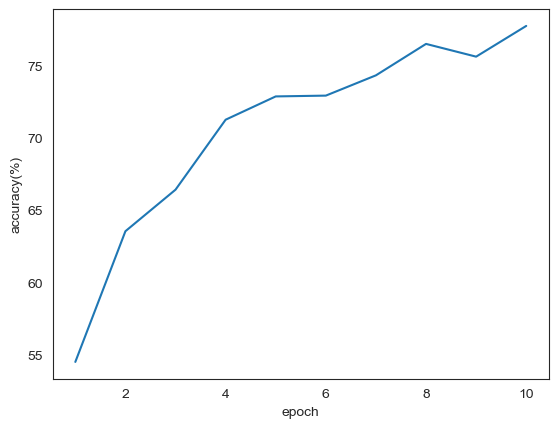

In [15]:
#Prediction on trainning data
plt.plot(range(1,epoch+2), train_rec)
plt.xlabel('epoch')
plt.ylabel('accuracy(%)')
accuracy(train_dl,classes,cnn,device)

Accuracy of the network on the images: 23.691460055096417 %

Accuracy for class: -0.05%~0.05% is 22.2 %
number of images in the class: 315
number of images predicted to be in the class: 470 

Accuracy for class: 0.05%~0.15% is 40.1 %
number of images in the class: 564
number of images predicted to be in the class: 678 

Accuracy for class: 0.15%~0.25% is 19.5 %
number of images in the class: 487
number of images predicted to be in the class: 350 

Accuracy for class: 0.25%~0.35% is 11.6 %
number of images in the class: 311
number of images predicted to be in the class: 201 

Accuracy for class: >0.35% is 2.2 %
number of images in the class: 138
number of images predicted to be in the class: 116 



23.691460055096417

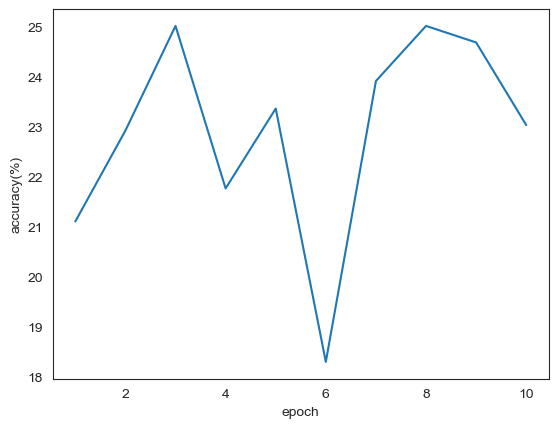

In [16]:
#Prediction on validation data
plt.plot(range(1,epoch+2), val_rec)
plt.xlabel('epoch')
plt.ylabel('accuracy(%)')
accuracy(val_dl,classes,cnn,device)